**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Parameter Initialization

In [1]:
import torch
import torchsummary
import torchvision

from matplotlib import pyplot as plt

## Constants

In [2]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
N_EPOCHS = 10
TRAIN_VAL_SPLIT = [55000, 5000]

## Loading the Data

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])

train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

train_set, val_set = torch.utils.data.random_split(train_set, TRAIN_VAL_SPLIT)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

## Defining the model

In [4]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=7,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Conv2d(
                in_channels=7,
                out_channels=19,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Conv2d(
                in_channels=19,
                out_channels=31,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features=31*32*32,
                out_features=1024,
            ),
            torch.nn.Tanh(),
            torch.nn.Linear(
                in_features=1024,
                out_features=10,
            )
        )

    
    def forward(self, x):
        return self.network(x)

In [5]:
model = Model()

torchsummary.summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 32, 32]              70
              Tanh-2            [-1, 7, 32, 32]               0
            Conv2d-3           [-1, 19, 32, 32]           1,216
              Tanh-4           [-1, 19, 32, 32]               0
            Conv2d-5           [-1, 31, 32, 32]           5,332
              Tanh-6           [-1, 31, 32, 32]               0
           Flatten-7                [-1, 31744]               0
            Linear-8                 [-1, 1024]      32,506,880
              Tanh-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
Total params: 32,523,748
Trainable params: 32,523,748
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.15
Params size (MB): 124.07
Est

In [6]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Baseline

In [7]:
def fit(model):

    accuracy_hist = []
    loss_hist = []
    val_accuracy_hist = []
    val_los_hist = []

    for epoch in range(N_EPOCHS):
        training_cost = 0.0
        training_correct = 0.0
        validation_cost = 0.0
        validation_correct = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            predictions = model(inputs)
            cost = loss_func(predictions, targets)
            cost.backward()
            optimizer.step()
            training_cost += cost.item()
            training_correct += (torch.argmax(predictions, dim=1) == targets).sum()
        training_cost /= len(train_set)
        training_correct /= len(train_set)
        print(f'epoch: {epoch}, loss: {training_cost}, accuracy: {training_correct}')
        accuracy_hist.append(training_correct)
        loss_hist.append(training_cost)

        with torch.no_grad():
            for inputs, targets in val_loader:
                predictions = model(inputs)
                cost = loss_func(predictions, targets)
                validation_cost += cost.item()
                validation_correct += (torch.argmax(predictions, dim=1) == targets).sum()
            validation_cost /= len(val_set)
            validation_correct /= len(val_set)
            print(f'Validation: loss: {validation_cost}, accuracy: {validation_correct}')
            val_accuracy_hist.append(validation_correct)
            val_los_hist.append(validation_cost)

    return accuracy_hist, loss_hist, val_accuracy_hist, val_los_hist

In [8]:
accuracy_hist, loss_hist, val_accuracy_hist, val_los_hist = fit(model)

epoch: 0, loss: 0.00543391284996813, accuracy: 0.7539272904396057
Validation: loss: 0.00422730541229248, accuracy: 0.807200014591217
epoch: 1, loss: 0.004128387912836942, accuracy: 0.8070726990699768
Validation: loss: 0.004166582232713699, accuracy: 0.8101999759674072
epoch: 2, loss: 0.003934411884979768, accuracy: 0.817509114742279
Validation: loss: 0.00407032014131546, accuracy: 0.8169999718666077
epoch: 3, loss: 0.0038263581714846873, accuracy: 0.8191454410552979
Validation: loss: 0.003849733817577362, accuracy: 0.828000009059906
epoch: 4, loss: 0.0038239337184212425, accuracy: 0.8211818337440491
Validation: loss: 0.0036200016617774964, accuracy: 0.8363999724388123
epoch: 5, loss: 0.0037562082231044768, accuracy: 0.8223090767860413
Validation: loss: 0.0038325217604637148, accuracy: 0.821399986743927
epoch: 6, loss: 0.0037410625766624104, accuracy: 0.8255272507667542
Validation: loss: 0.003595848608016968, accuracy: 0.8331999778747559
epoch: 7, loss: 0.0036751279023560612, accuracy: 

## Training Visualization

In [9]:
def plot(accuracy_hist, loss_hist, val_accuracy_hist, val_los_hist):
    f = plt.figure(figsize=(18, 6))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(accuracy_hist, label='Training')
    ax1.plot(val_accuracy_hist, label='Validation')
    ax1.title.set_text('Accuracy')
    ax1.legend()
    ax1.grid()
    ax2.plot(loss_hist, label='Training')
    ax2.plot(val_los_hist, label='Validation')
    ax2.title.set_text('Loss')
    ax2.legend()
    ax2.grid()

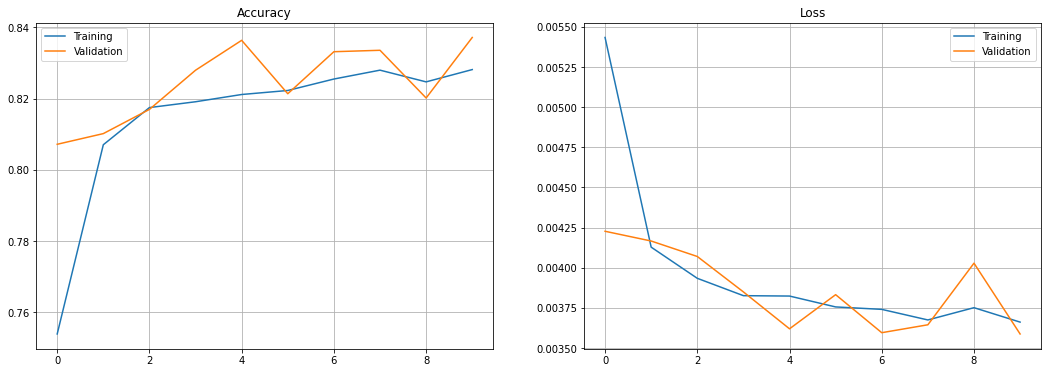

In [10]:
plot(accuracy_hist, loss_hist, val_accuracy_hist, val_los_hist)

## Manually initialize the weights

### Kaiming He ReLU 0 Bias

In [11]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.kaiming_uniform_(layer.weight.data, nonlinearity='relu')
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(layer.weight.data)
        torch.nn.init.constant_(layer.bias.data, 0)

In [12]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [13]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
he_accuracy_hist, he_loss_hist, he_val_accuracy_hist, he_val_los_hist = fit(model)

epoch: 0, loss: 0.006612803829258138, accuracy: 0.7373272776603699
Validation: loss: 0.004754496711492538, accuracy: 0.7824000120162964
epoch: 1, loss: 0.004499737935174595, accuracy: 0.7897454500198364
Validation: loss: 0.004198976397514344, accuracy: 0.8047999739646912
epoch: 2, loss: 0.0042980052227323704, accuracy: 0.7979817986488342
Validation: loss: 0.004096925014257431, accuracy: 0.8123999834060669
epoch: 3, loss: 0.004177960514480417, accuracy: 0.803600013256073
Validation: loss: 0.004402820140123367, accuracy: 0.796999990940094
epoch: 4, loss: 0.004188479945334521, accuracy: 0.8049818277359009
Validation: loss: 0.004249430185556412, accuracy: 0.8082000017166138
epoch: 5, loss: 0.00416658895611763, accuracy: 0.8045636415481567
Validation: loss: 0.004418223106861114, accuracy: 0.8062000274658203
epoch: 6, loss: 0.004162924508614973, accuracy: 0.8042363524436951
Validation: loss: 0.0038323921263217924, accuracy: 0.8230000138282776
epoch: 7, loss: 0.004083485406095331, accuracy: 0

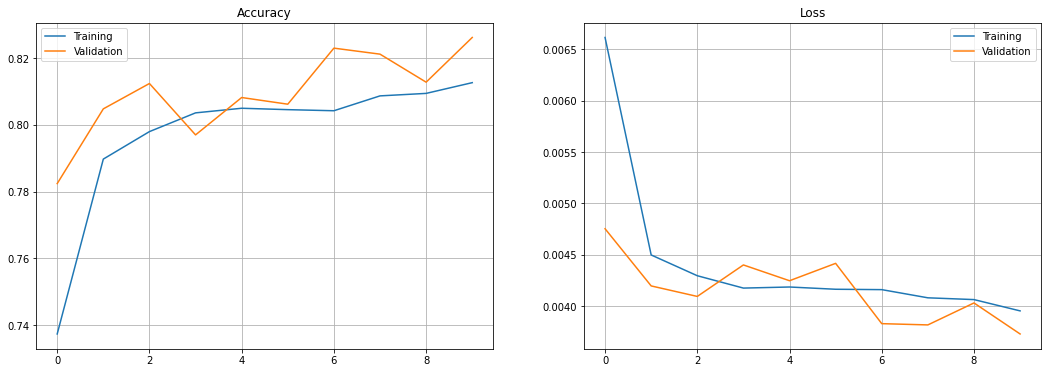

In [15]:
plot(he_accuracy_hist, he_loss_hist, he_val_accuracy_hist, he_val_los_hist)

### 0 Weights 0 Bias

In [16]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.constant_(layer.weight.data, 0)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.constant_(layer.weight.data, 0)
        torch.nn.init.constant_(layer.bias.data, 0)

In [17]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [18]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
zero_accuracy_hist, zero_loss_hist, zero_val_accuracy_hist, zero_val_los_hist = fit(model)

epoch: 0, loss: 0.018002820366079156, accuracy: 0.09860000014305115
Validation: loss: 0.018421083545684815, accuracy: 0.10000000149011612
epoch: 1, loss: 0.018002686764977197, accuracy: 0.09967272728681564
Validation: loss: 0.018423166370391847, accuracy: 0.09260000288486481
epoch: 2, loss: 0.01800292655771429, accuracy: 0.0989999994635582
Validation: loss: 0.018424240016937255, accuracy: 0.09260000288486481
epoch: 3, loss: 0.01800275197462602, accuracy: 0.09783636033535004
Validation: loss: 0.018423278331756592, accuracy: 0.09560000151395798
epoch: 4, loss: 0.018002645713632758, accuracy: 0.09920000284910202
Validation: loss: 0.01842245545387268, accuracy: 0.09260000288486481
epoch: 5, loss: 0.01800272189053622, accuracy: 0.0989818200469017
Validation: loss: 0.01842305293083191, accuracy: 0.10000000149011612
epoch: 6, loss: 0.01800277621529319, accuracy: 0.09865454584360123
Validation: loss: 0.018422692584991456, accuracy: 0.09260000288486481
epoch: 7, loss: 0.018002759976820513, accu

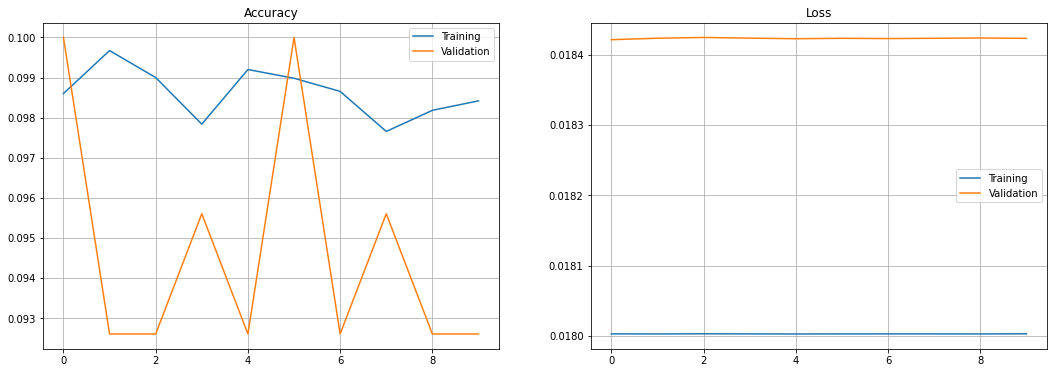

In [20]:
plot(zero_accuracy_hist, zero_loss_hist, zero_val_accuracy_hist, zero_val_los_hist)

### Standard normal Weights 0 Bias

In [21]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.normal_(layer.weight.data)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.normal_(layer.weight.data)
        torch.nn.init.constant_(layer.bias.data, 0)

In [22]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [23]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
normal_accuracy_hist, normal_loss_hist, normal_val_accuracy_hist, normal_val_los_hist = fit(model)

epoch: 0, loss: 0.10576257592981513, accuracy: 0.46480000019073486
Validation: loss: 0.07048065671920777, accuracy: 0.5329999923706055
epoch: 1, loss: 0.06158029623898593, accuracy: 0.5533454418182373
Validation: loss: 0.05538609865903854, accuracy: 0.573199987411499
epoch: 2, loss: 0.048973485825278544, accuracy: 0.5739636421203613
Validation: loss: 0.0461546000957489, accuracy: 0.5666000247001648
epoch: 3, loss: 0.041208357442509044, accuracy: 0.5884000062942505
Validation: loss: 0.039426491165161136, accuracy: 0.5853999853134155
epoch: 4, loss: 0.036686828071420846, accuracy: 0.593927264213562
Validation: loss: 0.0347969765663147, accuracy: 0.5907999873161316
epoch: 5, loss: 0.032477668877081436, accuracy: 0.5908545255661011
Validation: loss: 0.032476507091522215, accuracy: 0.5803999900817871
epoch: 6, loss: 0.029992651614275844, accuracy: 0.5927636623382568
Validation: loss: 0.028935916137695313, accuracy: 0.6019999980926514
epoch: 7, loss: 0.0280932748187672, accuracy: 0.595345437

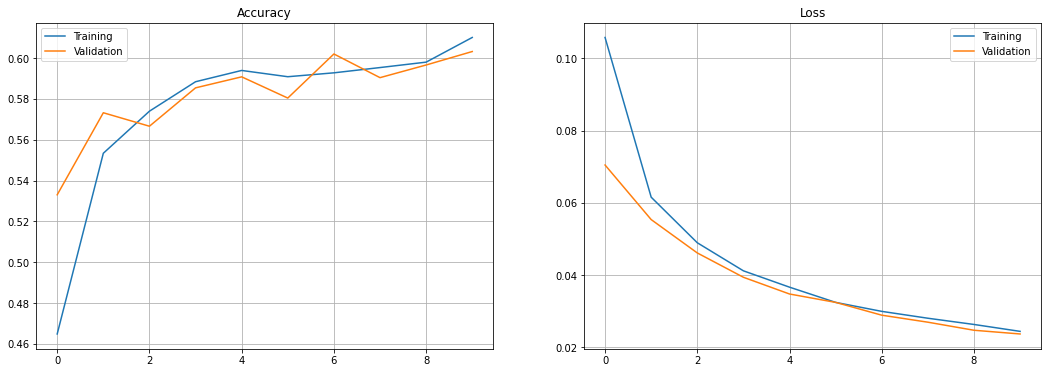

In [25]:
plot(normal_accuracy_hist, normal_loss_hist, normal_val_accuracy_hist, normal_val_los_hist)

### Uniform Weights 0 Bias

In [26]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.uniform_(layer.weight.data)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.uniform_(layer.weight.data)
        torch.nn.init.constant_(layer.bias.data, 0)

In [27]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [28]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [29]:
uni_accuracy_hist, uni_loss_hist, uni_val_accuracy_hist, uni_val_los_hist = fit(model)

epoch: 0, loss: 0.0198298162503676, accuracy: 0.12110909074544907
Validation: loss: 0.01887187728881836, accuracy: 0.14399999380111694
epoch: 1, loss: 0.017995781178907915, accuracy: 0.14709091186523438
Validation: loss: 0.018319073915481567, accuracy: 0.14839999377727509
epoch: 2, loss: 0.01767440988367254, accuracy: 0.16920000314712524
Validation: loss: 0.017788852214813234, accuracy: 0.1881999969482422
epoch: 3, loss: 0.017400478516925465, accuracy: 0.18307273089885712
Validation: loss: 0.017989957189559938, accuracy: 0.1785999983549118
epoch: 4, loss: 0.017307713768698954, accuracy: 0.19018182158470154
Validation: loss: 0.017498419713974, accuracy: 0.19840000569820404
epoch: 5, loss: 0.016952706202593718, accuracy: 0.20656363666057587
Validation: loss: 0.01758808205127716, accuracy: 0.1956000030040741
epoch: 6, loss: 0.01677524032159285, accuracy: 0.22152727842330933
Validation: loss: 0.017144838118553163, accuracy: 0.22460000216960907
epoch: 7, loss: 0.016553138854286886, accuracy

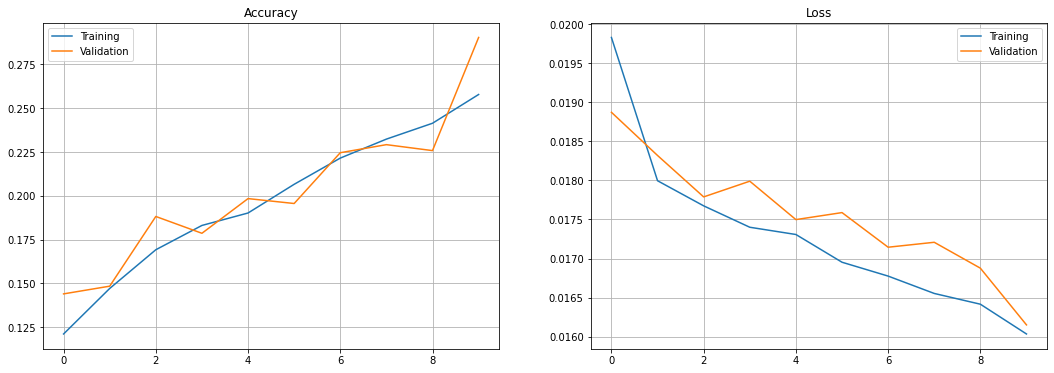

In [30]:
plot(uni_accuracy_hist, uni_loss_hist, uni_val_accuracy_hist, uni_val_los_hist)

### Xavier Glorot Tanh 0 Bias

In [31]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(layer.weight.data, torch.nn.init.calculate_gain('tanh'))
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight.data)
        torch.nn.init.constant_(layer.bias.data, 0)

In [32]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [33]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [34]:
glo_accuracy_hist, glo_loss_hist, glo_val_accuracy_hist, glo_val_los_hist = fit(model)

epoch: 0, loss: 0.006739341208067807, accuracy: 0.7314363718032837
Validation: loss: 0.0046641153216362, accuracy: 0.7875999808311462
epoch: 1, loss: 0.004481426967274059, accuracy: 0.7903090715408325
Validation: loss: 0.004358959239721298, accuracy: 0.7950000166893005
epoch: 2, loss: 0.004254676524075595, accuracy: 0.8002545237541199
Validation: loss: 0.0041352897226810455, accuracy: 0.8077999949455261
epoch: 3, loss: 0.004142741993882439, accuracy: 0.8056363463401794
Validation: loss: 0.004177733045816421, accuracy: 0.8050000071525574
epoch: 4, loss: 0.00401447500965812, accuracy: 0.8115817904472351
Validation: loss: 0.004245238006114959, accuracy: 0.8065999746322632
epoch: 5, loss: 0.004023706366799095, accuracy: 0.812781810760498
Validation: loss: 0.0041180292069911955, accuracy: 0.8091999888420105
epoch: 6, loss: 0.00396109339594841, accuracy: 0.8147454261779785
Validation: loss: 0.003969699019193649, accuracy: 0.8176000118255615
epoch: 7, loss: 0.003916777547923001, accuracy: 0.8

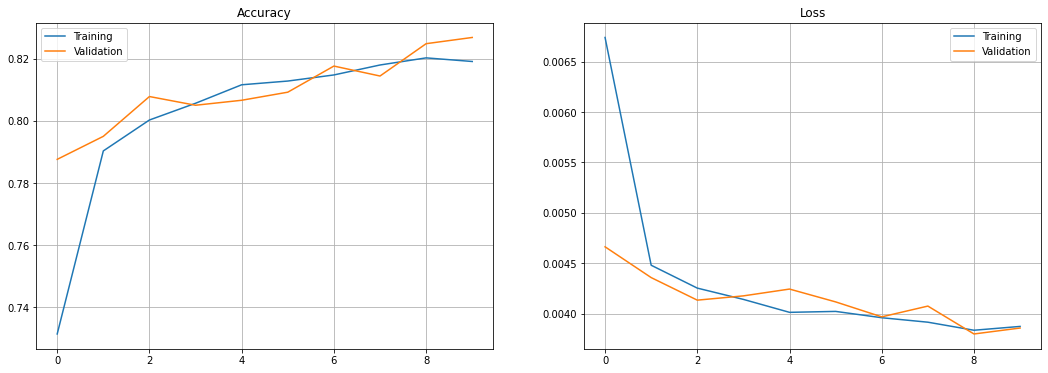

In [35]:
plot(glo_accuracy_hist, glo_loss_hist, glo_val_accuracy_hist, glo_val_los_hist)

## Comparison

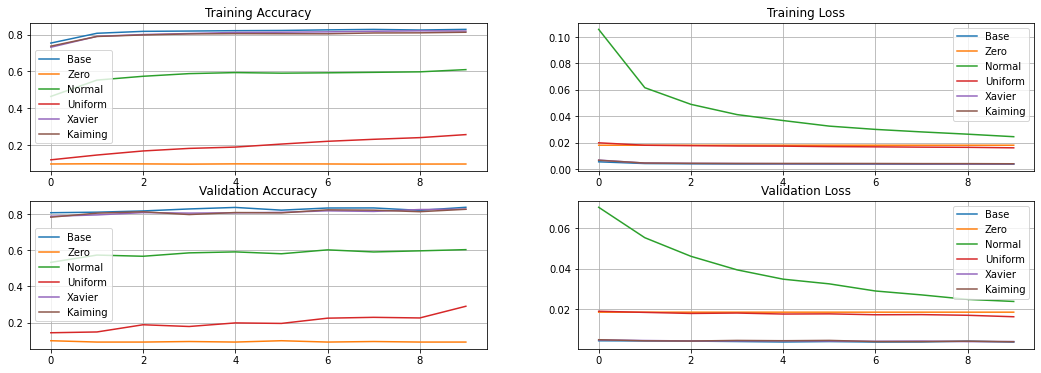

In [36]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
ax1.plot(accuracy_hist, label='Base')
ax1.plot(zero_accuracy_hist, label='Zero')
ax1.plot(normal_accuracy_hist, label='Normal')
ax1.plot(uni_accuracy_hist, label='Uniform')
ax1.plot(glo_accuracy_hist, label='Xavier')
ax1.plot(he_accuracy_hist, label='Kaiming')
ax1.title.set_text('Training Accuracy')
ax1.legend()
ax1.grid()
ax2.plot(loss_hist, label='Base')
ax2.plot(zero_loss_hist, label='Zero')
ax2.plot(normal_loss_hist, label='Normal')
ax2.plot(uni_loss_hist, label='Uniform')
ax2.plot(glo_loss_hist, label='Xavier')
ax2.plot(he_loss_hist, label='Kaiming')
ax2.title.set_text('Training Loss')
ax2.legend()
ax2.grid()
ax3.plot(val_accuracy_hist, label='Base')
ax3.plot(zero_val_accuracy_hist, label='Zero')
ax3.plot(normal_val_accuracy_hist, label='Normal')
ax3.plot(uni_val_accuracy_hist, label='Uniform')
ax3.plot(glo_val_accuracy_hist, label='Xavier')
ax3.plot(he_val_accuracy_hist, label='Kaiming')
ax3.title.set_text('Validation Accuracy')
ax3.legend()
ax3.grid()
ax4.plot(val_los_hist, label='Base')
ax4.plot(zero_val_los_hist, label='Zero')
ax4.plot(normal_val_los_hist, label='Normal')
ax4.plot(uni_val_los_hist, label='Uniform')
ax4.plot(glo_val_los_hist, label='Xavier')
ax4.plot(he_val_los_hist, label='Kaiming')
ax4.title.set_text('Validation Loss')
ax4.legend()
ax4.grid()

## Discussion

The results do seem reasonable. The ones initialized with more complex base values do provide higher accuracy compared to the ones with a simpler approach. Somewhat surprising is the fact that the one initialized with zeros is bound to its initial accuracy. Whereas the other ones can at least all improve over time. This experiment also shows that the people behind pytorch have not simply chosen random values for initialization, but that the out-of-the-box version is actually the most performant one.
While the `Normal` version seems to converge at a lower level than the top performers, the `Uniform` one seems to still be able to gain more performance. It would be interesting how much further this goes and what value it converges towards. It would most definitely require a whole lot of epochs more than the top performers.
We can see that `Base` is the best option closely followed by both `Xavier` and `Kaiming`.